In [1]:
from PIL import Image
from PIL import ExifTags


img = Image.open("sample.jpg")
exif = {ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS}
old_focal_mm = exif["FocalLength"]
new_focal_mm_multiplier = 3.
if new_focal_mm_multiplier <= 1.:
    raise ValueError('new_focal_mm_multiplier cannot be <= 1')
new_focal_mm = float(new_focal_mm_multiplier * old_focal_mm)
print(f'{old_focal_mm} -> {new_focal_mm}')


5.1 -> 15.299999999999999


In [2]:
from PIL import Image


depth = Image.open("sample-depth.jpg")

img = img.resize(size=depth.size)
# depth = depth.resize(size=img.size)

img.size, depth.size


((576, 768), (576, 768))

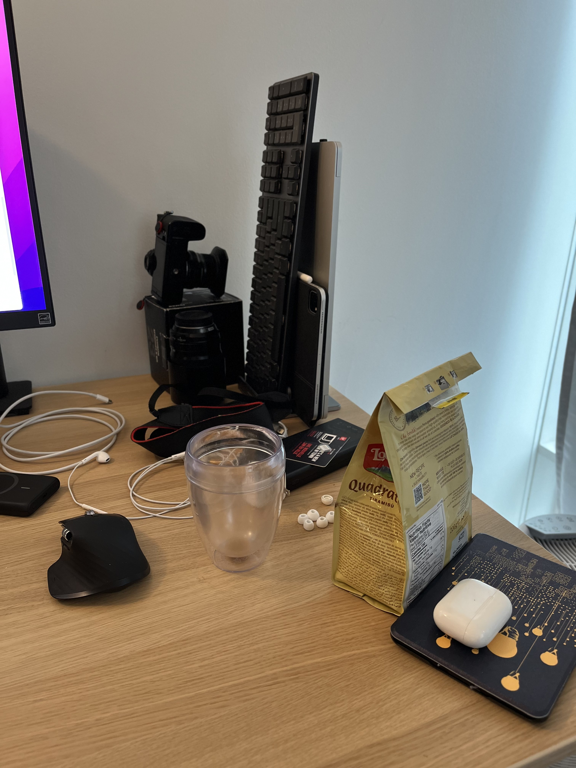

In [3]:
img

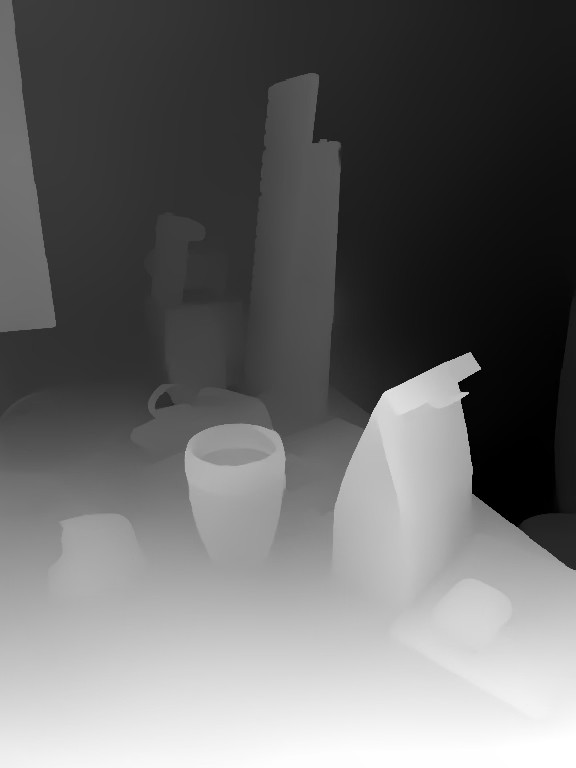

In [4]:
depth

In [5]:
import numpy as np

img_arr = np.asarray(img)
depth_arr = np.asarray(depth)[:, :, 0] # any channel is the same since it's black and white
img_arr.shape, depth_arr.shape

((768, 576, 3), (768, 576))

(array([64834., 91009., 67788., 27546., 23236., 13297., 39971., 41586.,
        36815., 36286.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

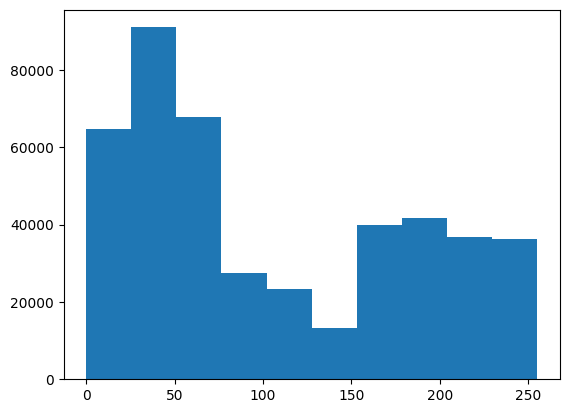

In [6]:
import matplotlib.pyplot as plt

plt.hist(depth_arr.reshape(-1))

In [7]:
# depth is in range(0, 256)
assert 0 == depth_arr.min() and depth_arr.max() == 255 

In [8]:
# create depth for effect
# d > old focal length and d > new focal length
# decrease depth_min_multiplier to exaggerate close-up effect
depth_min_multiplier, depth_max_multiplier = 2., 10.
depth_min = depth_min_multiplier * max(new_focal_mm, old_focal_mm)
depth_max = depth_max_multiplier * max(new_focal_mm, old_focal_mm)
depth_min, depth_max

(30.599999999999998, 153.0)

In [9]:
depth_arr_transformed = depth_min + (depth_arr / 256) * (depth_max - depth_min)
depth_arr_transformed.min(), depth_arr_transformed.max()

(30.599999999999998, 152.521875)

(array([64834., 91009., 67788., 27546., 23236., 13297., 39971., 41586.,
        36815., 36286.]),
 array([ 30.6      ,  42.7921875,  54.984375 ,  67.1765625,  79.36875  ,
         91.5609375, 103.753125 , 115.9453125, 128.1375   , 140.3296875,
        152.521875 ]),
 <BarContainer object of 10 artists>)

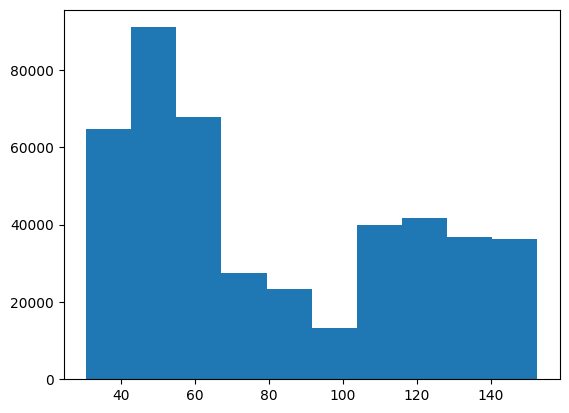

In [10]:
import matplotlib.pyplot as plt

plt.hist(depth_arr_transformed.reshape(-1))

In [11]:
def get_scaling(old_f_in_mm, new_f_in_mm, depth_in_mm) -> float:
    if depth_in_mm < min(new_f_in_mm, old_f_in_mm):
        raise ValueError('Depth cannot be smaller than new_f_in_mm or old_f_in_mm')
    res = (new_f_in_mm / (depth_in_mm - new_f_in_mm))
    res = res / (old_f_in_mm / (depth_in_mm - old_f_in_mm))
    return res


# focal length is proportional to image size
assert get_scaling(2, 3, 5) > 1
assert get_scaling(3, 2, 5) < 1
# for long distances, image size change is focal length change (i.e. zooming)
assert np.abs(get_scaling(3, 2, 1e9) - 2 / 3) < 1e-3


In [12]:
from tqdm import tqdm

size_x, size_y = img.size
new_img_arr = np.zeros(shape=img_arr.shape, dtype=np.uint8)

# start writing the furthest transformed pixels
for d in tqdm(sorted(np.unique(depth_arr_transformed), reverse=True)):
    scaling = get_scaling(old_f_in_mm=old_focal_mm, new_f_in_mm=new_focal_mm, depth_in_mm=d)
    # don't shift for long distances
    scaling = scaling / (new_focal_mm / old_focal_mm)

    new_size_x, new_size_y = int(size_x * scaling), int(size_y * scaling)
    # print(f'd: {d:.2f}, scaling: {scaling:.2f}')

    img_arr_d = np.zeros(shape=img_arr.shape, dtype=np.uint8)
    img_arr_d[depth_arr_transformed == d] = img_arr[depth_arr_transformed == d]
    img_d = (
        Image
        .fromarray(img_arr_d)
        .resize((new_size_x, new_size_y))
        .crop(box=(
            (new_size_x - size_x) // 2,
            (new_size_y - size_y) // 2, 
            size_x, 
            size_y
        ))
        .resize((size_x, size_y))
    )
    img_arr_d = np.asarray(img_d)
    new_img_arr[img_arr_d > 0] = img_arr_d[img_arr_d > 0]

100%|██████████| 256/256 [00:03<00:00, 77.04it/s]


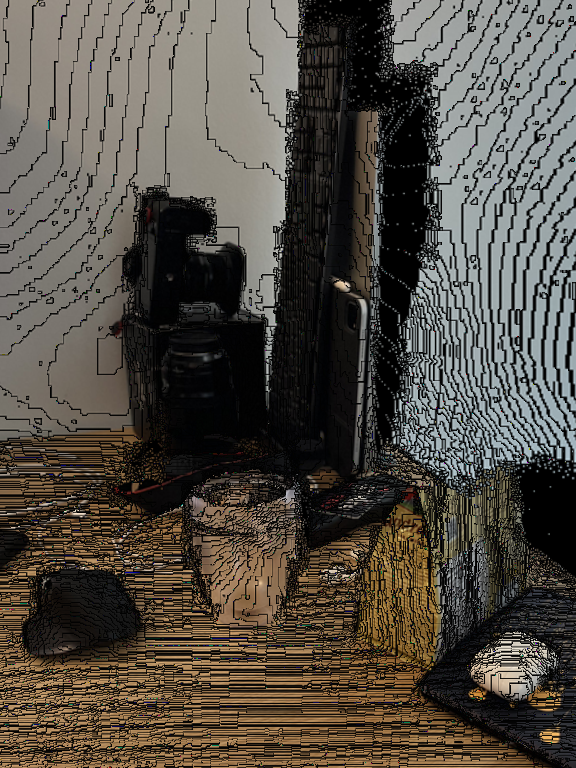

In [13]:
Image.fromarray(new_img_arr)